In [111]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [71]:
df = pd.read_csv('parking_citations.corrupted.csv', dtype=object)

## data clean up

In [72]:
# get rid of the data without "make" info
df_make = df.loc[~df['Make'].isnull()]

In [73]:
df_make['Issue Date'] = pd.to_datetime(df_make['Issue Date'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [74]:
# got rid of any without an expiration date
df_make = df_make.loc[~(df_make['Plate Expiry Date'].isnull())]

# only keep records with the right expiry dates
df_make = df_make.loc[df_make['Plate Expiry Date'].str.len() == 8]

# extract year and month 
df_make['year'] = df_make['Plate Expiry Date'].str[:4].astype('int')
df_make['month'] = df_make['Plate Expiry Date'].str[4:6].astype('int')
df_make['day'] = 1

# make sure the date is within a realistic timeframe
df_make = df_make.loc[(df_make['year'].between(1990, 2020, inclusive=True))&(df_make['month'].between(1, 12, inclusive=True))]

# recreate the plate expiration date field
df_make['plate_expiry_date'] = pd.to_datetime(df_make[['year', 'month', 'day']])


In [81]:
# making a subjective call and getting rid of fields that seems to not add to the analysis
# marked time is dropped because too many (>90%) are null
# I thought street type could possibly be useful for creating a feature but it seems time consuming given this scope
# agency might have some info but it's hard to immediately see the use without perhaps a lookup table
# lat and lon seem to not be actually usable at all
df_make = df_make.drop(['Ticket number', 'Meter Id', 'VIN', 'Latitude', 'Longitude', 'Agency', 'year', 'month', 'day', 'street_type', 'Marked Time'], axis = 1)

In [83]:
df_make.head()

,Issue Date,Issue time,Marked Time,RP State Plate,Plate Expiry Date,Make,Body Style,Color,Location,Route,Violation code,Violation Description,Fine amount,plate_expiry_date
6,2015-12-17,1710.0,NaN,CA,201605.0,MAZD,PA,BL,SUNSET/ALVARADO,00217,8070,PARK IN GRID LOCK ZN,163.0,2016-05-01
10,2015-12-22,1100.0,NaN,CA,201511.0,FORD,TR,WH,1159 HUNTLEY DR,2A75,8069AA,NO STOP/STAND AM,93.0,2015-11-01
11,2015-12-22,1105.0,NaN,CA,201701.0,CHRY,PA,GO,1159 HUNTLEY DR,2A75,8069AA,NO STOP/STAND AM,93.0,2017-01-01
14,2015-12-27,1055.0,NaN,CA,201605.0,TOYO,PA,BK,3100 N HOLLYRIDGE DR,NaN,8058L,PREF PARKING,68.0,2016-05-01
19,2015-12-22,1102.0,NaN,CA,201606.0,HOND,PA,BK,PLATA/RAMPART,2A1,8069B,NO PARKING,73.0,2016-06-01


## feature creation

In [84]:
# creating an "instate" field
df_make['instate'] = 0 
df_make.loc[df_make['RP State Plate'] == 'CA', 'instate'] = 1

In [85]:
# create an "expired" field
df_make['expired'] = 0
df_make.loc[(df_make['plate_expiry_date'] < df_make['Issue Date']), 'expired'] = 1

In [93]:
# create a "top 25" make field
top_25 = df['Make'].value_counts(normalize = True)[:25]
df_make['top_25_make'] = np.where(df_make['Make'].isin(top_25.index), 1, 0)

In [87]:
# bin the colors into top 10
top_colors = df_make['Color'].value_counts(normalize = True).cumsum()[:10]
df_make['Color'] = np.where(df_make['Color'].isin(top_colors.index), df_make['Color'], 'Other')

In [89]:
# bin the styles into top 5
top_style = df_make['Body Style'].value_counts(normalize = True).cumsum()[:5]
df_make['Body Style'] = np.where(df_make['Body Style'].isin(top_style.index), df_make['Body Style'], 'Other')

In [101]:
# extract location to see road type
df_make['street_type'] = df_make['Location'].str.split().str[-1]

In [112]:
# creating a categorical variable for fine amount
df_make['Fine amount'].astype('float').describe()

count   3660234.000
mean         69.667
std          32.457
min          10.000
25%          63.000
50%          68.000
75%          73.000
max         505.000
Name: Fine amount, dtype: float64

In [114]:
conditions = [
    (df_make['Fine amount'].astype('float').between(0,50)),
    (df_make['Fine amount'].astype('float').between(50,100))]
choices = ['low', 'medium']
df_make['fine_cat'] = np.select(conditions, choices, default='big')

In [130]:
# get num of days between ticket issued and plate expiration
df_make['days_between_issue_expired'] = (df_make['plate_expiry_date'] - df_make['Issue Date']).dt.days

In [127]:
# creating a categorical variable for issue time
conditions = [
    (df_make['Issue time'].astype('float').between(0,600)), # early hours
    (df_make['Issue time'].astype('float').between(600,1200)), # morning
    (df_make['Issue time'].astype('float').between(1200,1800)), # afternoon
]
choices = ['early_hours', 'morning', 'afternoon']
df_make['issue_time_cat'] = np.select(conditions, choices, default='night')

## questions to ask when comparing top 25 to non-25
1. related to the car: color, body style, plate expiration (is it expired? days since expiration?)
2. related to the ticket: issue date, time, fine amount, violation description
3. related to geography: location (type of street), state, lat, lon


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8726014 entries, 0 to 8726013
Data columns (total 19 columns):
Ticket number            object
Issue Date               object
Issue time               object
Meter Id                 object
Marked Time              object
RP State Plate           object
Plate Expiry Date        object
VIN                      object
Make                     object
Body Style               object
Color                    object
Location                 object
Route                    object
Agency                   object
Violation code           object
Violation Description    object
Fine amount              object
Latitude                 object
Longitude                object
dtypes: object(19)
memory usage: 1.2+ GB


## make/color/body style

In [39]:
# what's the top 25 make?
df['Make'].nunique()

1477

In [40]:
top_25 = df['Make'].value_counts(normalize = True)[:25]

In [41]:
# percent of total cars that are top 25 makes
top_25.sum()

0.9147845667192346

In [42]:
# create a boolean which tells you if it is or isn't top 25
df['top_25'] = np.where(df['Make'].isin(top_25.index), 1, 0)

In [43]:
# what are the top 10 colors?
top_colors = df['Color'].value_counts(normalize = True).cumsum()[:10]

In [44]:
# let's bin the rest of the colors in seperate
df['top_colors'] = np.where(df['Color'].isin(top_colors.index), df['Color'], 'Other')

In [45]:
# let's get a cross tab of top 25 make with top colors
cross_color = (pd.crosstab(df['top_25'], df['top_colors'], margins=True).T
.sort_values(by = 'All', ascending = False))

cross_color['zero_per'] = cross_color[0]/cross_color['All']
cross_color['one_per'] = cross_color[1]/cross_color['All']
cross_color['diff'] = abs(cross_color['zero_per']-cross_color['one_per'])

In [46]:
cross_color

top_25,0,1,All,zero_per,one_per,diff
top_colors,,,,,,
All,4739800,3986214,8726014,0.543180,0.456820,0.086361
BK,1018920,860989,1879909,0.542005,0.457995,0.084010
WT,987633,822299,1809932,0.545674,0.454326,0.091348
GY,894986,796864,1691850,0.528998,0.471002,0.057997
SL,574426,518328,1092754,0.525668,0.474332,0.051336
BL,368795,309982,678777,0.543323,0.456677,0.086646
Other,285278,212994,498272,0.572535,0.427465,0.145069
RD,238028,194645,432673,0.550134,0.449866,0.100267
GN,138369,111922,250291,0.552833,0.447167,0.105665


In [64]:
# body style 
top_style = df['Body Style'].value_counts(normalize = True).cumsum()[:5]

In [65]:
# let's bin the rest of the colors in seperate
df['top_style'] = np.where(df['Body Style'].isin(top_style.index), df['Body Style'], 'Other')

In [67]:
# let's get a cross tab of top 25 make with top style
cross_style = (pd.crosstab(df['top_25'], df['top_style'], margins=True).T
.sort_values(by = 'All', ascending = False))

cross_style['zero_per'] = cross_style[0]/cross_style['All']
cross_style['one_per'] = cross_style[1]/cross_style['All']
cross_style['diff'] = abs(cross_style['zero_per']-cross_style['one_per'])

In [68]:
cross_style

top_25,0,1,All,zero_per,one_per,diff
top_style,,,,,,
All,4739800,3986214,8726014,0.543180,0.456820,0.086361
PA,4119206,3554770,7673976,0.536776,0.463224,0.073552
PU,150580,148317,298897,0.503786,0.496214,0.007571
VN,125758,107747,233505,0.538567,0.461433,0.077133
TK,140387,72884,213271,0.658256,0.341744,0.316513
Other,109314,56788,166102,0.658114,0.341886,0.316227
CM,94555,45708,140263,0.674126,0.325874,0.348253


In [69]:
# conclusion: it seems like the new top style and top color might make for good predictors

## modeling

In [132]:
# dropping unnecessary vars
df_make.head()

,Issue Date,Issue time,RP State Plate,Plate Expiry Date,Make,Body Style,Color,Route,Violation code,Violation Description,Fine amount,plate_expiry_date,instate,expired,top_25_make,fine_cat,issue_time_cat,days_between_issue_expired
6,2015-12-17,1710.0,CA,201605.0,MAZD,PA,BL,00217,8070,PARK IN GRID LOCK ZN,163.0,2016-05-01,1,0,1,big,afternoon,136
10,2015-12-22,1100.0,CA,201511.0,FORD,Other,WH,2A75,8069AA,NO STOP/STAND AM,93.0,2015-11-01,1,1,1,medium,morning,-51
11,2015-12-22,1105.0,CA,201701.0,CHRY,PA,GO,2A75,8069AA,NO STOP/STAND AM,93.0,2017-01-01,1,0,1,medium,morning,376
14,2015-12-27,1055.0,CA,201605.0,TOYO,PA,BK,NaN,8058L,PREF PARKING,68.0,2016-05-01,1,0,1,medium,morning,126
19,2015-12-22,1102.0,CA,201606.0,HOND,PA,BK,2A1,8069B,NO PARKING,73.0,2016-06-01,1,0,1,medium,morning,162


In [137]:
df_make = df_make.drop(['Issue Date', 'Issue time', 'RP State Plate', 'Plate Expiry Date', 'Make',  'Route', 'Violation code', 'Violation Description', 'plate_expiry_date'], axis=1)

In [139]:
df_make.head()

,Body Style,Color,Fine amount,instate,expired,top_25_make,fine_cat,issue_time_cat,days_between_issue_expired
6,PA,BL,163.0,1,0,1,big,afternoon,136
10,Other,WH,93.0,1,1,1,medium,morning,-51
11,PA,GO,93.0,1,0,1,medium,morning,376
14,PA,BK,68.0,1,0,1,medium,morning,126
19,PA,BK,73.0,1,0,1,medium,morning,162


In [142]:
df_make['Fine amount'] = df_make['Fine amount'].astype('float')

In [160]:
df_make['Fine amount'] = df_make['Fine amount'].fillna(value=0)

In [161]:
df_make.isnull().sum()

Body Style                    0
Color                         0
Fine amount                   0
instate                       0
expired                       0
top_25_make                   0
fine_cat                      0
issue_time_cat                0
days_between_issue_expired    0
dtype: int64

In [162]:
df_make_model = pd.get_dummies(df_make)

In [185]:
df_make_model.columns

Index(['Fine amount', 'instate', 'expired', 'top_25_make',
       'days_between_issue_expired', 'Body Style_CM', 'Body Style_Other',
       'Body Style_PA', 'Body Style_PU', 'Body Style_TK', 'Body Style_VN',
       'Color_BK', 'Color_BL', 'Color_GN', 'Color_GO', 'Color_GY', 'Color_MR',
       'Color_Other', 'Color_RD', 'Color_SL', 'Color_WH', 'Color_WT',
       'fine_cat_big', 'fine_cat_low', 'fine_cat_medium',
       'issue_time_cat_afternoon', 'issue_time_cat_early_hours',
       'issue_time_cat_morning', 'issue_time_cat_night'],
      dtype='object')

## making the model

In [164]:
X = df_make_model.loc[:, df_make_model.columns != 'top_25_make']
y = df_make_model.loc[:, df_make_model.columns == 'top_25_make']

In [165]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [171]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.92


In [173]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.40      0.00      0.00     84543
           1       0.92      1.00      0.96   1014316

    accuracy                           0.92   1098859
   macro avg       0.66      0.50      0.48   1098859
weighted avg       0.88      0.92      0.89   1098859



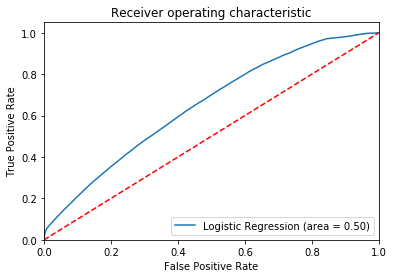

In [177]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
%matplotlib inline
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


In [187]:
import pickle
pickle.dump(logreg, open('final_prediction.pickle', 'wb'))

In [188]:
df.columns

Index(['Ticket number', 'Issue Date', 'Issue time', 'Meter Id', 'Marked Time',
       'RP State Plate', 'Plate Expiry Date', 'VIN', 'Make', 'Body Style',
       'Color', 'Location', 'Route', 'Agency', 'Violation code',
       'Violation Description', 'Fine amount', 'Latitude', 'Longitude'],
      dtype='object')